In [1]:
import pandas as pd
import os
confirmed = pd.read_csv("https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps&format=csv")


/var/folders/f6/g40wkt31081__rgmtbr2q2l00000gn/T/ipykernel_50678/1355475981.py:3: DtypeWarning: Columns (153,183,187,206,211,237,242) have mixed types. Specify dtype option on import or set low_memory=False.
  confirmed = pd.read_csv("https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps&format=csv")


In [2]:
confirmed['disc_facility']

0                                     OGLE
1                     La Silla Observatory
2                     La Silla Observatory
3        Okayama Astrophysical Observatory
4                      Paranal Observatory
                       ...                
38383                               Kepler
38384                               Kepler
38385                               Kepler
38386                               Kepler
38387                               Kepler
Name: disc_facility, Length: 38388, dtype: object

In [3]:
confirmed_tess = confirmed[confirmed['disc_facility'].str.contains("TESS", na=False)]

In [4]:
confirmed_tess_unique = confirmed_tess.drop_duplicates(subset="pl_name")
confirmed_tess_unique

,pl_name,pl_letter,hostname,hd_name,hip_name,tic_id,gaia_id,default_flag,pl_refname,sy_refname,...,sy_jmagerr1,sy_jmagerr2,sy_jmagstr,sy_hmag,sy_hmagerr1,sy_hmagerr2,sy_hmagstr,sy_kmag,sy_kmagerr1,sy_kmagerr2
60,HD 108236 e,e,HD 108236,HD 108236,HIP 60689,TIC 260647166,Gaia DR2 6125644402384918784,0,<a refstr=EXOFOP_TESS_TOI href=https://exofop....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,0.024,-0.024,8.046&plusmn;0.024,7.703,0.029,-0.029,7.703&plusmn;0.029,7.637,0.031,-0.031
61,HD 108236 c,c,HD 108236,HD 108236,HIP 60689,TIC 260647166,Gaia DR2 6125644402384918784,0,<a refstr=EXOFOP_TESS_TOI href=https://exofop....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,0.024,-0.024,8.046&plusmn;0.024,7.703,0.029,-0.029,7.703&plusmn;0.029,7.637,0.031,-0.031
79,HD 108236 b,b,HD 108236,HD 108236,HIP 60689,TIC 260647166,Gaia DR2 6125644402384918784,0,<a refstr=KOKORI_ET_AL__2023 href=https://ui.a...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,0.024,-0.024,8.046&plusmn;0.024,7.703,0.029,-0.029,7.703&plusmn;0.029,7.637,0.031,-0.031
81,HD 108236 d,d,HD 108236,HD 108236,HIP 60689,TIC 260647166,Gaia DR2 6125644402384918784,0,<a refstr=KOKORI_ET_AL__2023 href=https://ui.a...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,0.024,-0.024,8.046&plusmn;0.024,7.703,0.029,-0.029,7.703&plusmn;0.029,7.637,0.031,-0.031
84,TOI-1174 b,b,TOI-1174,NaN,NaN,TIC 154089169,Gaia DR2 1674293361400214272,0,<a refstr=EXOFOP_TESS_TOI href=https://exofop....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,0.017,-0.017,9.467&plusmn;0.017,9.031,0.019,-0.019,9.031&plusmn;0.019,8.964,0.022,-0.022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21602,TOI-251 b,b,TOI-251,NaN,NaN,TIC 224225541,Gaia DR2 6539037542941988736,0,<a refstr=PATEL__AMP__ESPINOZA_2022 href=https...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,0.020,-0.020,8.766&plusmn;0.020,8.498,0.044,-0.044,8.498&plusmn;0.044,8.426,0.027,-0.027
21625,TOI-558 b,b,TOI-558,NaN,NaN,TIC 207110080,Gaia DR2 4727755005637190016,0,<a refstr=EXOFOP_TESS_TOI href=https://exofop....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,0.026,-0.026,10.581&plusmn;0.026,10.309,0.028,-0.028,10.309&plusmn;0.028,10.262,0.023,-0.023
21716,TOI-1221 b,b,TOI-1221,NaN,NaN,TIC 349095149,Gaia DR2 5282270089967734912,1,<a refstr=MANN_ET_AL__2023 href=https://ui.ads...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,0.023,-0.023,9.433&plusmn;0.023,9.089,0.022,-0.022,9.089&plusmn;0.022,9.036,0.021,-0.021
21879,TOI-2338 b,b,TOI-2338,NaN,NaN,TIC 24358417,Gaia DR2 4822916912388338176,0,<a refstr=EXOFOP_TESS_TOI href=https://exofop....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,0.026,-0.026,11.076&plusmn;0.026,10.746,0.025,-0.025,10.746&plusmn;0.025,10.664,0.025,-0.025


In [5]:
import lightkurve as lk
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle
import astropy.units as u

In [6]:
planet_names = confirmed_tess_unique["pl_name"].dropna().tolist()

In [7]:
def fold(lc, period, t0):
    t0_btjd = t0 - 2457000
    return lc.fold(period=period, epoch_time=t0_btjd)

class TESSPlanetTransit:
    def __init__(self, name, period=None, t0=None, lc = None, depth=None, duration=None, impact=None):
        self.name = name
        self.period = period
        self.t0 = t0
        folded_lc = fold(lc, period, t0)
        self.time = np.array(folded_lc.time.value)
        self.flux = np.array(folded_lc.flux.value)
        self.depth = depth
        self.duration = duration
        self.impact = impact
    
    


I only downloaded 1 dataset (1 sector) for each TESS planet, and then phase-folded the dataset. This is probably not the best idea... But downloading all the datasets took forever! It might also be better to not phase-fold.

In [8]:
transits = []
output_path = "transitsconditional.pkl"
if not os.path.exists(output_path):
    with open(output_path, "wb") as f:
        pass
for planet in tqdm(planet_names):
    try:
        row = confirmed_tess_unique[confirmed_tess_unique["pl_name"] == planet]
        period = row["pl_orbper"].values[0]
        t0 = row["pl_tranmid"].values[0]
        duration = row["pl_trandur"].values[0]
        depth = row["pl_trandep"].values[0]
        impact = row["pl_imppar"].values[0]
        if np.isnan(period) or np.isnan(t0) or np.isnan(duration) or np.isnan(depth) or np.isnan(impact):
            continue
        search = lk.search_lightcurve(planet, mission="TESS", author="SPOC")
        if len(search) == 0:
            continue
        search = search[search.exptime == 120 * u.s]
        if len(search) == 0:
            continue
        
        
        for lc_file in search:
            try:
                lc = lc_file.download()
                if lc is None:
                    continue
                transit = TESSPlanetTransit(planet, period, t0, lc, depth, duration, impact)
                transits.append(transit)
                with open(output_path, "ab") as f:
                    pickle.dump(transit, f)
            except Exception as e:
                print(f"Skipping sector for {planet}: {e}")
    except Exception as e:
            print(f"Error processing {planet}: {e}")
        
        
            


100%|██████████| 620/620 [13:34<00:00,  1.31s/it]


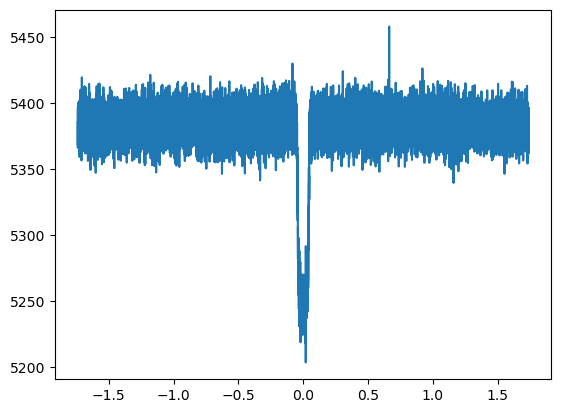

In [9]:
plt.plot(transits[200].time, np.array(transits[200].flux))

In [10]:
with open("transits_raw_condition.pkl", "wb") as f:
    pickle.dump(transits, f)